# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Novas Tecnologias em Banco de Dados</b></center></font>
  
<font size="3"><center>Prof. Dra. Sahudy Montenegro González</center></font>

## <center>Projeto Prático - CONAB COTAÇÕES</center>

**GRUPO 03**

**Nome**: Mateus Tsuyoshi Matsuo Hashimoto e Pedro Gonçalves Correia

**RA**: 813500 e 813281


---
### Web Scraping

Nesta seção, será realizada a implementação do código referente ao web scraping do site da Companhia Nacional de Abastecimento (CONAB) a fim de extrair os dados a respeito das cotações dos insumos agropecuários.

Como o site possui um captcha de imagem para acessar as tabelas contendo os dados das consultas, o que impossibilitou o web scraping por meio do WebDriver. Porém, a partir de algumas análises, o grupo descobriu uma forma de extrair os dados do site. Essa maneira consiste em utilizar uma url base e, a partir dela, gerar as urls para todas as consultas e, assim, conseguir extrair todos os dados do site. 

Após realizar uma consulta manualmente, o grupo verificou que o link da página possuía o seguinte formato: https://consultaweb.conab.gov.br/consultas/consultaInsumo.do?d-6983528-p=1&uf=&anoFinal=2024&ano=2020&method=acaoListarConsulta&idSubGrupo=28&btnConsultar=Consultar&jcaptcha=WBLDS&idGrupo=9

Sendo:
* <b>"https://consultaweb.conab.gov.br/consultas/consultaInsumo.do"</b>: a url base;
* <b>"p=1"</b>: a paginação da tabela;
* <b>"uf="</b>: a UF selecionada para a consulta;
* <b>"anoFinal=2024"</b>: o ano final do intervalo de tempo da consulta;
* <b>"ano=2020"</b>: o ano inicial do intervalo de tempo da consulta;
* <b>"method=acaoListarConsulta"</b>: o método do sistema para listar os dados da consulta;
* <b>"idSubGrupo=28"</b>: o id do SubGrupo selecionado para a consulta;
* <b>"btnConsultar=Consultar"</b>: o botão de confirmar a consulta;
* <b>"jcaptcha=WBLDS"</b>: o captcha utilizado para realizar a consulta;
* <b>"idGrupo=9"</b>: o id do Grupo selecionado para a consulta.


Com base nisso, o grupo alterou o link manualmente para verificar se seria possível realizar uma consulta diferente com o mesmo captcha, a fim de tentar solucionar essa questão impeditiva até então. Felizmente, foi possível concluir essa consulta graças à uma falha de segurança no sistema do site. A partir disso, a equipe realizou o código do web scraping a seguir.  

Primeiramente, vamos realizar a importação das bibliotecas que serão utilizadas no projeto.

In [1]:
import requests  # Realiza requisições HTTP para acessar páginas web
from bs4 import BeautifulSoup  # Faz parsing do HTML e extração de informações de páginas web
import pandas as pd  # Manipula e analisa dados, especialmente em dataframes
import time  # Permite controlar o tempo, inserindo delays entre requisições

Agora, vamos estabelecer a url base e os parâmetros fixos.

In [2]:
# url base
url = "https://consultaweb.conab.gov.br/consultas/consultaInsumo.do"

# Parâmetros fixos
ANO_INICIAL = 2020
ANO_FINAL = 2024
JCAPTCHA = "WBLDS"

A seguir, criaremos 3 dicionários fundamentais para realizar o web scraping desse site.

O primeiro dicionário serve para associar os grupos com os seus subgrupos por meio do id, para poder realizar todas as consultas possíveis.

In [3]:
grupos_subgrupos = {
    9: [28, 29, 30, 31, 33, 35],
    27: [32, 70, 71],
    31: [127, 128, 129],
    57: [137, 319, 339],
    39: [139, 140, 322]
}

O segundo e o terceiro dicionário servem para mapear os ids dos grupos para os seus nomes e os ids dos subgrupos para os seus nomes, respectivamente. Esses dicionários têm como objetivo armazenar os nomes dos grupos e subgrupos, uma vez que as tabelas resultantes das consultas só possuem os nomes dos produtos. 

In [4]:
# Dicionário para mapear os IDs para os nomes dos grupos
grupos_nomes = {
    9: "Agrotóxico",
    27: "Fertilizante",
    31: "Implemento",
    57: "Máquinas/Motores",
    39: "Material Propagativo"
}

# Dicionário para mapear os IDs para os nomes dos subgrupos
subgrupos_nomes = {
    28: "Acaricida",
    29: "Espalhante/Adjuvante",
    30: "Fungicida",
    31: "Herbicida",
    33: "Inseticida",
    35: "Estimulante/Regulador de Crescimento",
    32: "Inoculante",
    70: "Orgânico",
    71: "Químico",
    127: "Colheitadeira",
    128: "Manual",
    129: "Mecânico",
    137: "Máquina Agrícola",
    319: "Conjunto",
    339: "Máquina",
    139: "Mudas",
    140: "Sementes",
    322: "Maniva"
}

Agora, vamos criar duas listas, uma para armazenar os dados coletados e outra para pegar os cabeçalhos da tabela.

In [5]:
data = [] # Lista para armazenar os dados coletados
headers = [] # Lista para armazenar os titulos das colunas

Em seguida, iremos extrair todos os dados das tabelas geradas a partir das consultas acessadas por meio da construção das urls.

In [6]:
# Loop para cada combinação de grupo e subgrupo
for id_grupo, subgrupos in grupos_subgrupos.items():
    for id_subgrupo in subgrupos:
        pagina = 1  # Começa na primeira página
        
        while True:
            # Parâmetros da requisição
            parametros = {
                "d-6983528-p": pagina,
                "uf": "",
                "anoFinal": ANO_FINAL,
                "ano": ANO_INICIAL,
                "method": "acaoListarConsulta",
                "idSubGrupo": id_subgrupo,
                "btnConsultar": "Consultar",
                "jcaptcha": JCAPTCHA,
                "idGrupo": id_grupo    
            }
            
            resposta = requests.get(url, params=parametros) # Fazendo a requisição
            
            print(resposta.url)
            
            # Verifica se a requisição foi bem-sucedida
            if resposta.status_code != 200:
                print(f"Erro ao acessar {resposta.url}: {resposta.status_code}")
                break
            
            soup = BeautifulSoup(resposta.text, 'html.parser') # Parseando a página
            table = soup.find('table', {'id': 'tabelaInsumo'}) # Encontra a tabela
            
            # Se não há dados, paramos a iteração
            if table is None:
                break
            
            # Na primeira iteração, extrai os headers
            if pagina == 1 and not data:
                for i in table.find_all('th'):
                    title = i.text.strip()
                    headers.append(title)
                headers.extend(['Grupo', 'Subgrupo']) # Acrescenta os headers de grupo e subgrupo
            
            page_data = [] # Lista para armazenar os dados da página
            
            # Extraindo dados da tabela
            for row in table.find_all('tr')[1:]:
                cols = row.find_all('td')
                row_data = [col.text.replace('\n', '').strip() for col in cols]
                grupo_valor = grupos_nomes.get(id_grupo) # Pega o valor(nome) do grupo pelo id_grupo
                subgrupo_valor = subgrupos_nomes.get(id_subgrupo) # Pega o valor(nome) do subgrupo pelo id_subgrupo
                row_data.extend([grupo_valor, subgrupo_valor]) # Adiciona o valor(nome) do grupo e subgrupo
                page_data.append(row_data)
            
            data.extend(page_data) # Armazena os dados coletados
            
            print(f"Grupo {id_grupo} | Subgrupo {id_subgrupo} | Página {pagina} | {len(page_data)} registros coletados.")
            
            pagina += 1 # Próxima página
            
            time.sleep(1) # Adiciona um pequeno delay para evitar sobrecarga no servidor

https://consultaweb.conab.gov.br/consultas/consultaInsumo.do?d-6983528-p=1&uf=&anoFinal=2024&ano=2020&method=acaoListarConsulta&idSubGrupo=28&btnConsultar=Consultar&jcaptcha=WBLDS&idGrupo=9
Grupo 9 | Subgrupo 28 | Página 1 | 75 registros coletados.
https://consultaweb.conab.gov.br/consultas/consultaInsumo.do?d-6983528-p=2&uf=&anoFinal=2024&ano=2020&method=acaoListarConsulta&idSubGrupo=28&btnConsultar=Consultar&jcaptcha=WBLDS&idGrupo=9
Grupo 9 | Subgrupo 28 | Página 2 | 32 registros coletados.
https://consultaweb.conab.gov.br/consultas/consultaInsumo.do?d-6983528-p=3&uf=&anoFinal=2024&ano=2020&method=acaoListarConsulta&idSubGrupo=28&btnConsultar=Consultar&jcaptcha=WBLDS&idGrupo=9
https://consultaweb.conab.gov.br/consultas/consultaInsumo.do?d-6983528-p=1&uf=&anoFinal=2024&ano=2020&method=acaoListarConsulta&idSubGrupo=29&btnConsultar=Consultar&jcaptcha=WBLDS&idGrupo=9
Grupo 9 | Subgrupo 29 | Página 1 | 75 registros coletados.
https://consultaweb.conab.gov.br/consultas/consultaInsumo.do?d-

Após a extração de todos os dados do site, vamos converte-los para um dataframe e salvá-los em um arquivo CSV.

In [7]:
df = pd.DataFrame(data, columns=headers)

In [8]:
df.to_csv('insumos_agropecuarios.csv', index=False)

---
### Limpeza e Pré-processamento dos dados

Nesta seção, vamos realizar a preparação dos dados extraídos pelo web scraping a fim de assegurar a qualidade deles.

Primeiro, iremos analisar algumas características desse conjunto de dados.

In [9]:
df.head()

,Produto,Unidade,UF,Ano,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Grupo,Subgrupo
0,"DANIMEN, 300 EC",L,RO,2020,"0,00","0,00","178,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","175,00","0,00",Agrotóxico,Acaricida
1,ENVIDOR,L,SP,2020,"0,00","0,00","525,00","525,00","0,00","0,00","0,00","0,00","0,00","0,00","468,17","0,00",Agrotóxico,Acaricida
2,"KUMULUS, 800 G/KG, ENXOFRE, BASF S.A., BENTLEY...",KG,SP,2020,"0,00","0,00","11,03","11,03","0,00","0,00","0,00","0,00","0,00","0,00","10,88","0,00",Agrotóxico,Acaricida
3,"OBERON, 240 G/L, ESPIROMESIFENO, BAYER S.A., 5...",L,BA,2020,"213,99","213,99","213,99","0,00","213,99","213,99","213,99","213,99","213,00","213,00","250,00","250,00",Agrotóxico,Acaricida
4,"OMITE, 300 G/KG, PROPARGITO, CROMPTON LTDA., R...",L,MG,2020,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","95,85","0,00",Agrotóxico,Acaricida


In [10]:
df.shape

(10677, 18)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10677 entries, 0 to 10676
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Produto   10677 non-null  object
 1   Unidade   10677 non-null  object
 2   UF        10677 non-null  object
 3   Ano       10677 non-null  object
 4   Jan       10677 non-null  object
 5   Fev       10677 non-null  object
 6   Mar       10677 non-null  object
 7   Abr       10677 non-null  object
 8   Mai       10677 non-null  object
 9   Jun       10677 non-null  object
 10  Jul       10677 non-null  object
 11  Ago       10677 non-null  object
 12  Set       10677 non-null  object
 13  Out       10677 non-null  object
 14  Nov       10677 non-null  object
 15  Dez       10677 non-null  object
 16  Grupo     10677 non-null  object
 17  Subgrupo  10677 non-null  object
dtypes: object(18)
memory usage: 1.5+ MB


A seguir, vamos transformar algumas variáveis categóricas em numéricas com o intuito de analisar os valores estatísticos delas.

In [12]:
cat = ['Ano', 'Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'] # Lista de colunas a serem convertidas para numéricas

for column in cat:
    df[column] = pd.to_numeric(df[column].astype(str).str.replace(',', ''), errors='coerce') # Remover o separador de milhar e converter para numérico

Após isso, criaremos uma nova variável para armazenar a região do país de cada cotação a partir de sua UF.

Para isso, será necessário criar um dicionário para o mapeamento de UF para região e depois, utilizar o método map( ) para criar a nova variável.

In [13]:
# Dicionário para mapear as regiões a partir das UFs
regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['GO', 'MT', 'MS', 'DF'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

uf_regiao = {uf: regiao for regiao, ufs in regioes.items() for uf in ufs} # Inverte o dicionário de regiões: para cada UF, associa-se sua região
df['Regiao'] = df['UF'].map(uf_regiao)

Agora, vamos reorganizar as colunas do dataframe para uma melhor visualização dos dados.

In [14]:
new_order = ['Grupo', 'Subgrupo', 'Produto', 'Unidade', 'Regiao', 'UF', 'Ano', 'Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'] # Lista com a nova ordem das colunas

df = df[new_order]

Para fins analíticos dos dados coletados, não iremos realizar o tratamento de valores nulos, pois vamos analisar se teve ou não produção de um determinado produto em um determinado mês/ano. Portanto, manter esses valores é de extrema importância para o objetivo do negócio.

In [ ]:
df.to_csv('insumos_agropecuarios_tratados.csv', index=False) # Salva o dataframe tratado em um arquivo CSV

---
### Integração com o banco de dados do PostgreSQL

Nesta seção, iremos conectar ao banco de dados do PostgreSQL para armazenar os dados coletados e pré-processados.

Primeiro, vamos importar a biblioteca SQLAlchemy para fazer essa conexão com o banco.

In [15]:
from sqlalchemy import create_engine

Agora, vamos estabelecer os dados de conexão com o banco local.

In [ ]:
username = '<seu_usuario>' 
password = '<sua_senha>'
host = '<host_da_conexao>'         
port = '<porta_da_conexao>'
database = '<nome_do_banco>'

Criaremos uma url de conexão, que é utilizada pela engine para estabelecer a conexão com o PostgreSQL

In [17]:
connection_string = f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}' # Cria a URL de conexão

engine = create_engine(connection_string) # Cria o engine

Após estabelecer a conexão e criar as tabelas de dimensão e de fato no Data Warehouse por meio do script 'DDL.sql', iremos realizar o povoamento delas.

---
### Povoamento do Data Warehouse - Dimensões e Tabela Fato

Nesta seção, será realizado o povoamento das tabelas do DW, diretamente do DataFrame.

Primeiro, vamos popular a Dimensão Local.

In [18]:
# Seleciona as colunas 'UF' e 'Regiao' do dataframe, remove as duplicadas e renomeia as colunas para igualar aos da tabela no PostgreSQL
df_local = df[['UF', 'Regiao']].drop_duplicates().rename(columns={'UF': 'estado', 'Regiao': 'regiao'})

# Insere o dataframe na tabela 'dim_local' do banco de dados
df_local.to_sql('dim_local', engine, if_exists='append', index=False)

print("Dimensão Local carregada.")

Dimensão Local carregada.


Agora, vamos popular a Dimensão Produto.

In [19]:
# Seleciona as colunas 'Produto', 'Subgrupo', 'Grupo' e 'Unidade' do dataframe, remove as duplicadas e renomeia as colunas para igualar aos da tabela no PostgreSQL
df_produto = df[['Produto', 'Subgrupo', 'Grupo', 'Unidade']].drop_duplicates().rename(columns={'Produto': 'nome_produto', 'Subgrupo': 'subgrupo', 'Grupo': 'grupo', 'Unidade': 'unidade_medida'})

# Insere o dataframe na tabela 'dim_produto' do banco de dados
df_produto.to_sql('dim_produto', engine, if_exists='append', index=False)

print("Dimensão Produto carregada.")

Dimensão Produto carregada.


Em seguida, vamos popular a Dimensão Data.

In [20]:
# Dicionário que mapeia o número do mês para seu nome por extenso
month_names = {
    1: 'Janeiro', 
    2: 'Fevereiro', 
    3: 'Março', 
    4: 'Abril', 
    5: 'Maio', 
    6: 'Junho',
    7: 'Julho', 
    8: 'Agosto', 
    9: 'Setembro', 
    10: 'Outubro', 
    11: 'Novembro', 
    12: 'Dezembro'
}

anos = sorted(df['Ano'].unique()) # Ordena os anos únicos presentes na coluna 'ano'
dim_data_rows = [] # Lista para armazenar os registros da dimensão de data

# Para cada ano e para cada mês (1 a 12), gera os registros com o trimestre correspondente
for ano in anos:
    for mes in range(1, 13):
        # Define o trimestre com base no mês:
        if mes in (1, 2, 3):
            trimestre = 1
        elif mes in (4, 5, 6):
            trimestre = 2
        elif mes in (7, 8, 9):
            trimestre = 3
        else:
            trimestre = 4
        
        # Cria um registro com mês, ano, nome do mês e trimestre
        dim_data_rows.append({
            'mes': mes,
            'ano': ano,
            'mes_por_extenso': month_names[mes],
            'trimestre': trimestre
        })

df_data = pd.DataFrame(dim_data_rows) # Converte a lista de registros em um DataFrame
df_data.to_sql('dim_data', engine, if_exists='append', index=False) # Insere o dataframe na tabela 'dimensao_data' do banco de dados

print("Dimensão Data carregada.")

Dimensão Data carregada.


Por último, vamos popular a Tabela Fato.

In [21]:
# Pega as colunas dos meses do DataFrame
month_cols = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Converte o DataFrame de formato wide (cada coluna representa um mês) para long (cada linha representa uma observação mensal), mantendo as colunas de identificação
df_fact = pd.melt(df,
                  id_vars=['UF', 'Regiao', 'Produto', 'Subgrupo', 'Grupo', 'Unidade', 'Ano'], # mantém as colunas de identificação
                  value_vars=month_cols, # transforma as colunas dos meses especificados
                  var_name='mes_nome', # coluna que contém os nomes dos meses
                  value_name='preco') # coluna que contém os preços

# Mapeia as abreviações dos meses para seus números correspondentes
month_mapping = {
    'Jan': 1, 
    'Fev': 2, 
    'Mar': 3, 
    'Abr': 4, 
    'Mai': 5, 
    'Jun': 6,
    'Jul': 7, 
    'Ago': 8, 
    'Set': 9, 
    'Out': 10, 
    'Nov': 11, 
    'Dez': 12
}

# Cria uma nova coluna 'Mes' com o número do mês correspondente
df_fact['Mes'] = df_fact['mes_nome'].map(month_mapping)

# Carrega as dimensões já populadas no banco de dados
df_local_dw = pd.read_sql("SELECT * FROM dim_local", engine)
df_produto_dw = pd.read_sql("SELECT * FROM dim_produto", engine)
df_data_dw = pd.read_sql("SELECT * FROM dim_data", engine)

# Realiza joins para agregar as chaves estrangeiras
df_fact = df_fact.merge(df_local_dw, left_on=['UF', 'Regiao'], right_on=['estado', 'regiao'], how='left')
df_fact = df_fact.merge(df_produto_dw, left_on=['Produto', 'Subgrupo', 'Grupo', 'Unidade'], right_on=['nome_produto', 'subgrupo', 'grupo', 'unidade_medida'], how='left')
df_fact = df_fact.merge(df_data_dw, left_on=['Mes', 'Ano'], right_on=['mes', 'ano'], how='left')

# Remove preços iguais a zero antes da inserção 
df_fact = df_fact[(df_fact['preco'] > 0)]

# Seleciona apenas as colunas necessárias para a tabela fato
df_fact_final = df_fact[['id_local', 'id_data', 'id_produto', 'preco']]

# Insere o dataframe na tabela 'fato_cotacao' do banco de dados
df_fact_final.to_sql('fato_cotacao', engine, if_exists='replace', index=False)

print("Tabela Fato carregada.")

Tabela Fato carregada.


---
### Análise dos resultados das consultas

Nesta seção, será realizada a análise dos resultados das consultas realizadas no PostgreSQL através do arquivo *consultas.sql*.

Como iremos plotar gráficos para auxiliar na análise dos resultados, vamos importar as bibliotecas *matpltolib* e *seaborn*.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

Recuperando os resultados da consulta 1.

In [33]:
query = "SELECT * FROM mv_preco_medio_tempo;" # Recupera os resultados da materialized view

df_consulta1 = pd.read_sql_query(query, engine) # Executa a consulta e armazena o resultado em um DataFrame

Para realizar a análise da consulta 1, iremos plotar um gráfico de linha que permite visualizar tendências e sazonalidade.

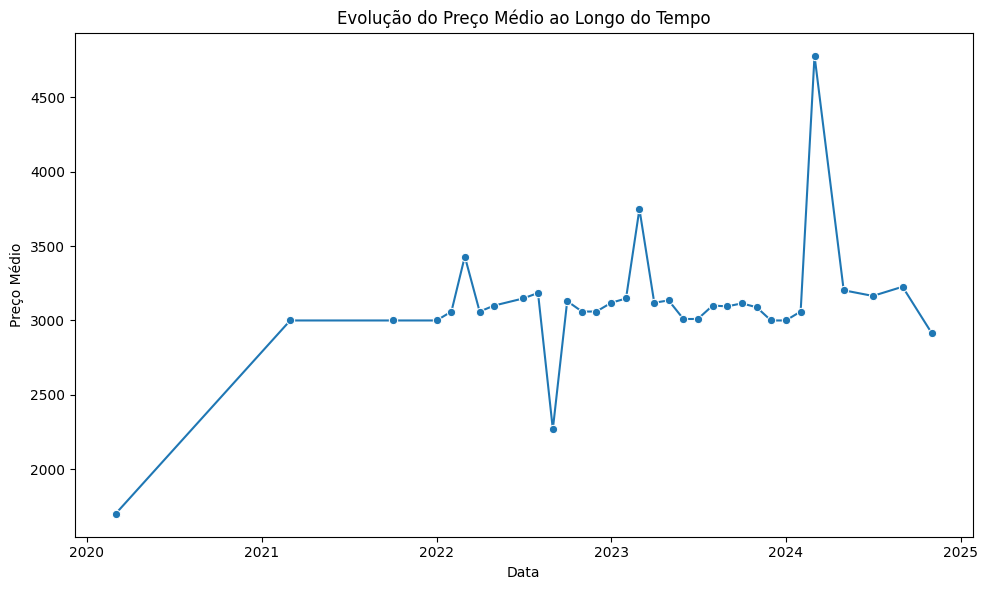

In [40]:
# Cria uma coluna 'date' combinando ano e mês
df_consulta1['date'] = pd.to_datetime(df_consulta1['ano'].astype(str) + '-' + df_consulta1['mes'].astype(str) + '-01')
df_consulta1 = df_consulta1.sort_values('date')

plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='preco_medio', data=df_consulta1, marker='o')
plt.title('Evolução do Preço Médio ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço Médio')
plt.tight_layout()
plt.show()

Conclusões a partir do gráfico: É possível observar que nos últimos 3 anos, no início desses anos teve um pico no preço do produto. 

Recuperando os resultados da consulta 2.

In [35]:
query = "SELECT * FROM mv_preco_medio_regiao;" # Recupera os resultados da materialized view

df_consulta2 = pd.read_sql_query(query, engine) # Executa a consulta e armazena o resultado em um DataFrame

Para realizar a análise da consulta 2, iremos plotar um gráfico de barras que facilita fazer a comparação entre as regiões.

C:\Users\mateu\AppData\Local\Temp\ipykernel_10016\3828021894.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='regiao', y='preco_medio', data=df_consulta2, palette='viridis')


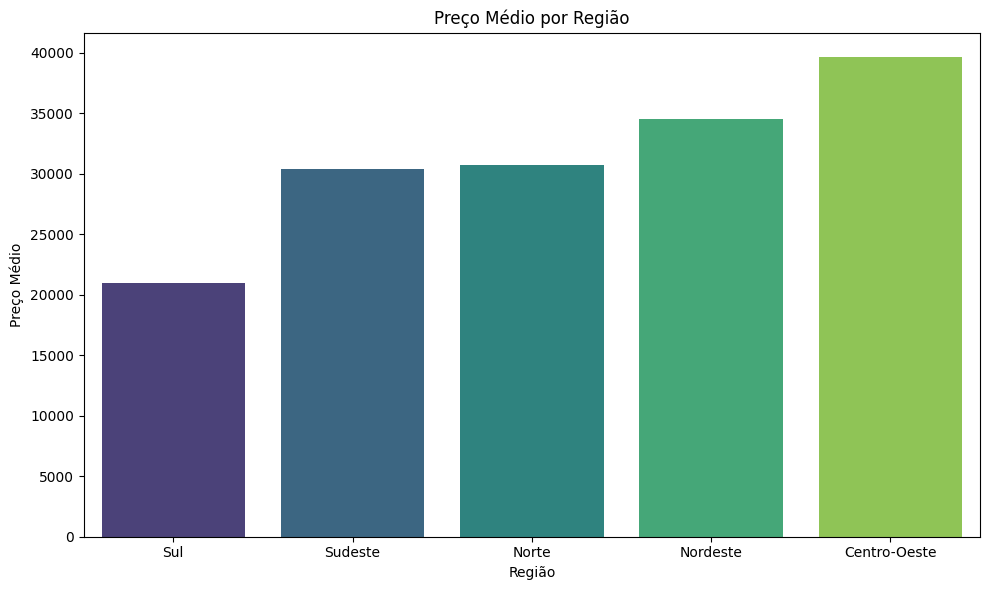

In [41]:
plt.figure(figsize=(10,6))
sns.barplot(x='regiao', y='preco_medio', data=df_consulta2, palette='viridis')
plt.title('Preço Médio por Região')
plt.xlabel('Região')
plt.ylabel('Preço Médio')
plt.tight_layout()
plt.show()

Recuperando os resultados da consulta 3.

In [37]:
# Recupera a consulta realizada por região
query = "SELECT * FROM mv_produtos_regiao;" # Recupera os resultados da materialized view
df_consulta3r = pd.read_sql_query(query, engine) # Executa a consulta e armazena o resultado em um DataFrame

# Recupera a consulta realizada por estado
query = "SELECT * FROM mv_produtos_estado;" # Recupera os resultados da materialized view
df_consulta3e = pd.read_sql_query(query, engine) # Executa a consulta e armazena o resultado em um DataFrame

Para realizar a análise da consulta 3, iremos plotar um gráfico de barras.

C:\Users\mateu\AppData\Local\Temp\ipykernel_10016\2428745129.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='grupo', y='count', data=df_count_grupo, palette='magma')


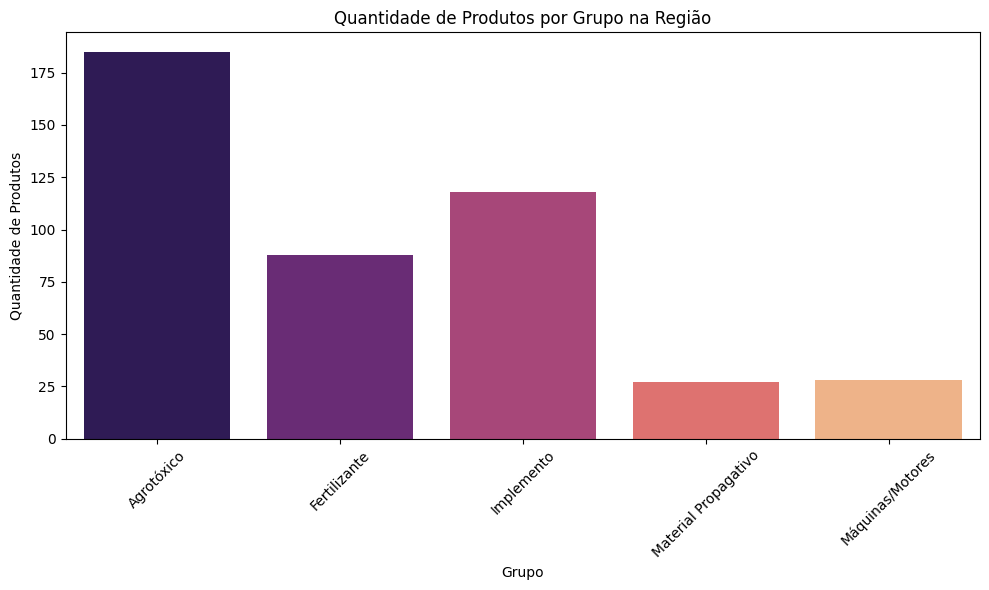

C:\Users\mateu\AppData\Local\Temp\ipykernel_10016\2428745129.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='subgrupo', y='count', data=df_count_subgrupo, palette='magma')


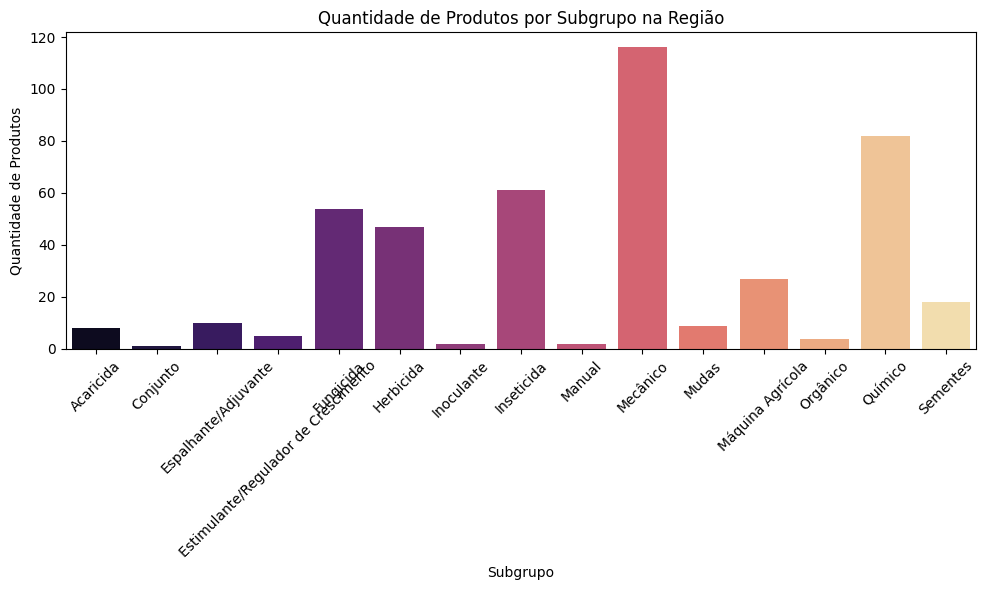

In [44]:
df_count_grupo = df_consulta3r.groupby('grupo').size().reset_index(name='count') # Contabiliza a quantidade de produtos por grupo

plt.figure(figsize=(10,6))
sns.barplot(x='grupo', y='count', data=df_count_grupo, palette='magma')
plt.title('Quantidade de Produtos por Grupo na Região')
plt.xlabel('Grupo')
plt.ylabel('Quantidade de Produtos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_count_subgrupo = df_consulta3r.groupby('subgrupo').size().reset_index(name='count') # Contabiliza a quantidade de produtos por subgrupo

plt.figure(figsize=(10,6))
sns.barplot(x='subgrupo', y='count', data=df_count_subgrupo, palette='magma')
plt.title('Quantidade de Produtos por Subgrupo na Região')
plt.xlabel('Subgrupo')
plt.ylabel('Quantidade de Produtos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\mateu\AppData\Local\Temp\ipykernel_10016\1663900493.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='grupo', y='count', data=df_count_grupo, palette='magma')


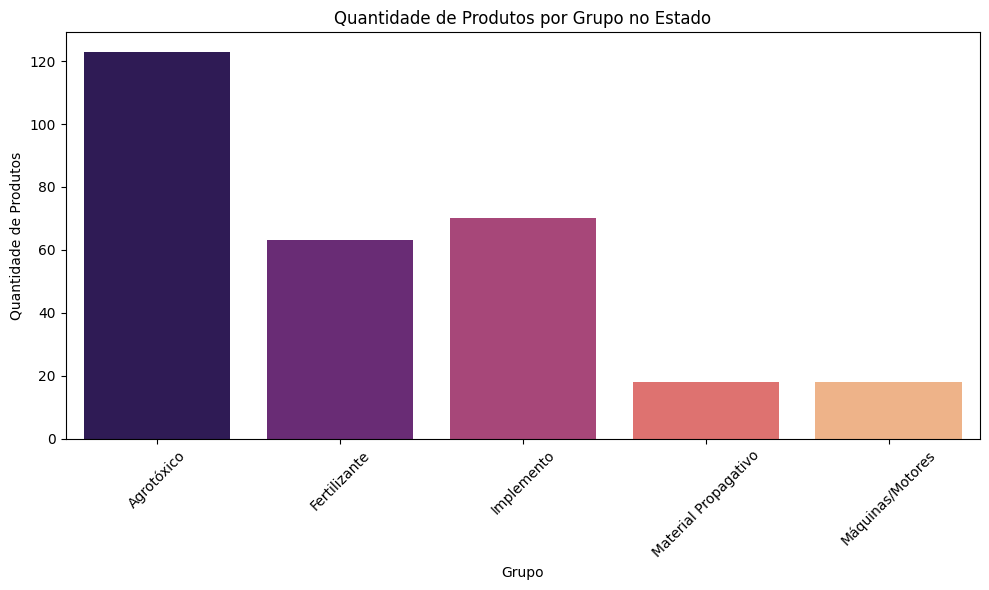

C:\Users\mateu\AppData\Local\Temp\ipykernel_10016\1663900493.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='subgrupo', y='count', data=df_count_subgrupo, palette='magma')


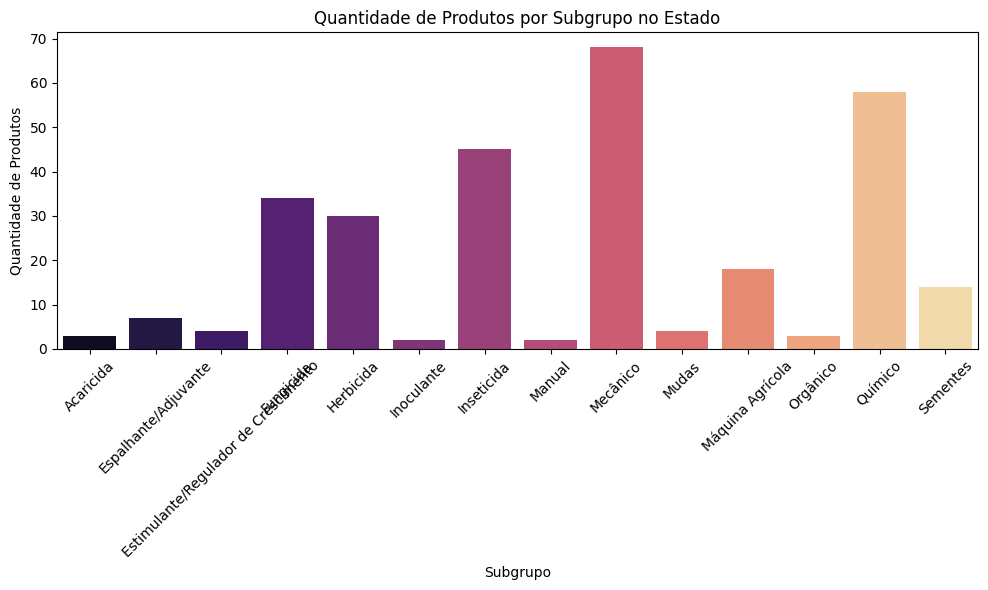

In [45]:
df_count_grupo = df_consulta3e.groupby('grupo').size().reset_index(name='count') # Contabiliza a quantidade de produtos por grupo

plt.figure(figsize=(10,6))
sns.barplot(x='grupo', y='count', data=df_count_grupo, palette='magma')
plt.title('Quantidade de Produtos por Grupo no Estado')
plt.xlabel('Grupo')
plt.ylabel('Quantidade de Produtos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_count_subgrupo = df_consulta3e.groupby('subgrupo').size().reset_index(name='count') # Contabiliza a quantidade de produtos por subgrupo

plt.figure(figsize=(10,6))
sns.barplot(x='subgrupo', y='count', data=df_count_subgrupo, palette='magma')
plt.title('Quantidade de Produtos por Subgrupo no Estado')
plt.xlabel('Subgrupo')
plt.ylabel('Quantidade de Produtos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Recuperando os resultados da consulta 4.

In [38]:
query = "SELECT * FROM mv_preco_tipo;" # Recupera os resultados da materialized view

df_consulta4 = pd.read_sql_query(query, engine) # Executa a consulta e armazena o resultado em um DataFrame

Para a análise da consulta 4, vamos plotar um gráfico de barras com barras de erro (indicando o desvio padrão).

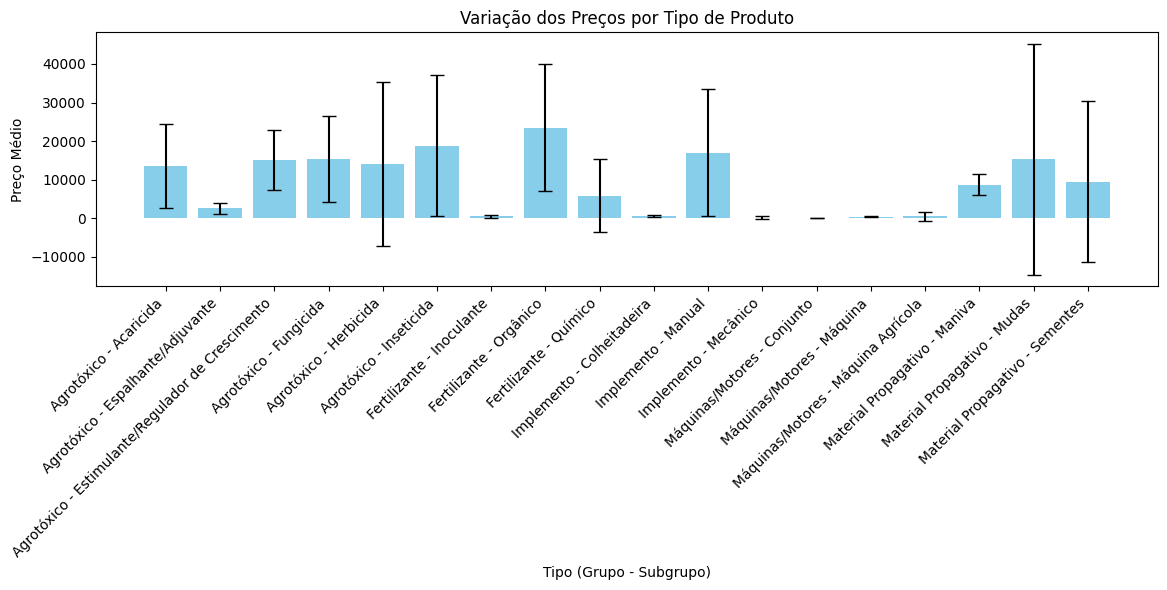

In [46]:
# Usando um gráfico de barras com erro para cada subgrupo (agrupados por grupo)
# Para facilitar a visualização, vamos criar uma coluna combinada para identificar o subgrupo
df_consulta4['tipo'] = df_consulta4['grupo'] + ' - ' + df_consulta4['subgrupo']

plt.figure(figsize=(12,6))
# Cria uma posição para cada tipo
x = range(len(df_consulta4))
plt.bar(x, df_consulta4['preco_medio'], yerr=df_consulta4['preco_desvio_padrao'], capsize=5, color='skyblue')
plt.xticks(x, df_consulta4['tipo'], rotation=45, ha='right')
plt.title('Variação dos Preços por Tipo de Produto')
plt.xlabel('Tipo (Grupo - Subgrupo)')
plt.ylabel('Preço Médio')
plt.tight_layout()
plt.show()